In [1]:
import sys
import os
import pickle

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import math

from pathlib import Path
from importlib import reload

# PATHS

In [2]:
path_data = '/home/lemasle/PROJECTS/UCI_electricity_consumption/data/UC_Irvine_ML_repository/'
path_src = Path('./src')
sys.path.append(os.path.abspath(path_src))
path_figs = Path('./figs')

# IMPORT: MODULES

In [3]:
import files_io as files_io
import cleaning as cleaning
import explore_vis as explore_vis
import features as features
import feature_vis as feature_vis
import data_prep as data_prep
import models as models
import model_vis as model_vis

cm = 1/2.54

# LOAD data

#### New features, lag values, and rescaling already done (see the data_exploration notebook)

In [4]:
train_h_sc = pd.read_csv(path_data + 'hourly_scaled_train_data.csv')
test_h_sc = pd.read_csv(path_data + 'hourly_scaled_test_data.csv')

In [5]:
# reset index of csv-loaded datato datetime format
train_h_sc.index = pd.to_datetime(train_h_sc.index)
test_h_sc.index = pd.to_datetime(test_h_sc.index)

# GOAL

#### We want to predict the Global active power

In [6]:
timeseries = 'Global_active_power'

#### We assume we do not know the global reactive power, thevoltage, or the intensity at a given time. If we did, we would not need to predict the global active power, we could simply compute it from physics

#### However, we know their past (=lag) values (we assume the value gets known within 1h, since this is our shorter time step).

#### Similarly, we assume that the the sub-meter values are not accessible to us

# PREPARE FEATURES 6 TRAIN/TEST DATA

In [7]:
# Initiate list of features
list_feat = train_h_sc.columns.to_list()

In [8]:
# Remove instantaneous values from the list of features
remove_list = ['Global_active_power',  'Global_reactive_power',  'Voltage', \
               'Global_intensity',  'Sub_metering_1', 'Sub_metering_2', \
               'Sub_metering_3', 'Sub_metering_rest', 'Global_active_power_scld', \
               'Global_reactive_power_scld',  'Voltage_scld',  'Global_intensity_scld', \
               'Sub_metering_1_scld',  'Sub_metering_2_scld',  'Sub_metering_3_scld', \
               'Sub_metering_rest_scld']
temp = [i for i in list_feat if i not in remove_list]

In [9]:
# Keep only scaled values in the list of features
list_feat = [i for i in temp if '_scld' in i]

#### Split train/test data based on year 

In [10]:
#### Jan-Nov 2010: test data
#### All the rest (Dec 2006 - dec D009): train data

In [11]:
train, ytrain, test, ytest = data_prep.select_Xy_for_model(train_h_sc, test_h_sc, \
                                                            timeseries, list_feat)

# LINEAR REGRESSION MODEL

In [12]:
mod_lin, fit_lin, pred_lin = models.sklearn_linear_regression(train, ytrain, test, ytest)

In [13]:
models.compute_evaluation_metrics(ytest, pred_lin, True)

Cannot compute MSLE (negative values)

MAE: 0.36518479011675176
MSE: 0.28323163908399807
MAPE: 0.4390435809733463
MSLE: nan


(0.36518479011675176, 0.28323163908399807, 0.4390435809733463, nan)

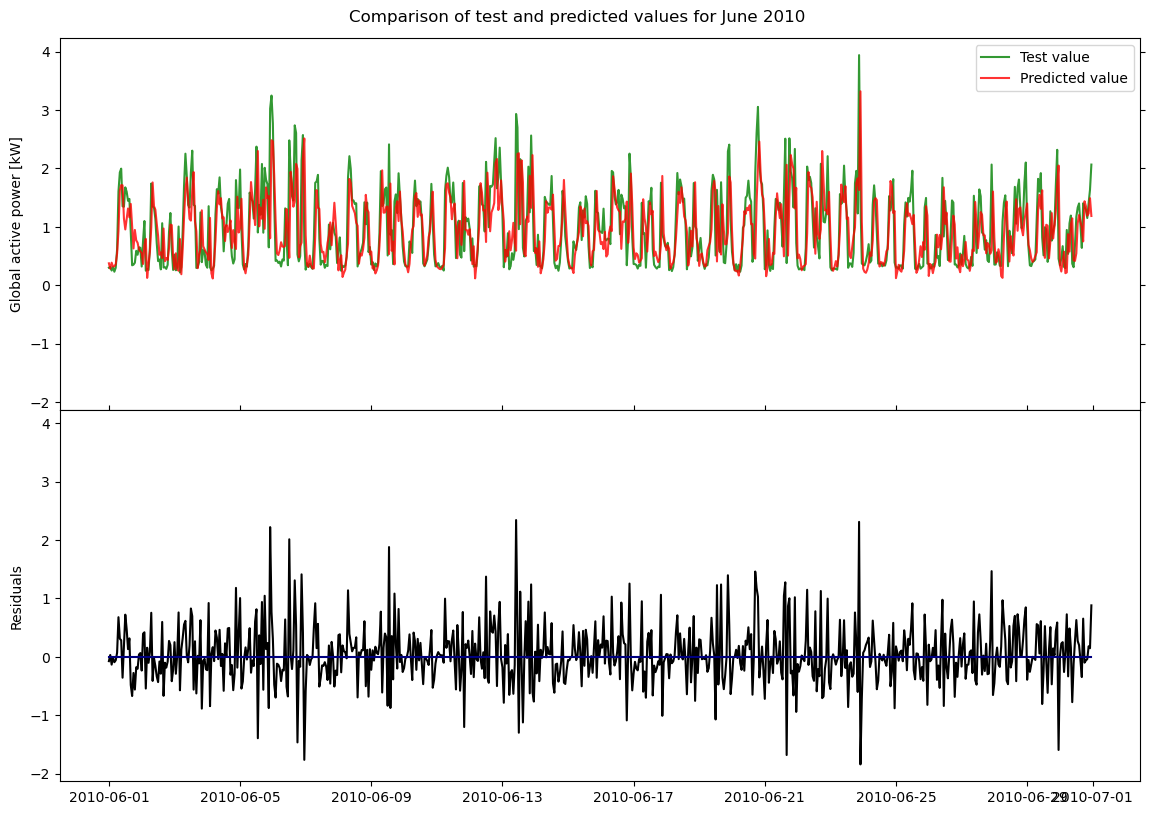

In [14]:
model_vis.plot_prediction_per_month(ytest, pred_lin, r'Global active power [kW]', 6, path_figs, \
                                    'Predictions_(linear_regression)_global_active_power.pdf', cm)

# RANDOM FOREST MODEL

In [15]:
n_est=100
r_st=1121218

Importance scores
 [0.07847833 0.02394041 0.00767913 0.00771714 0.00701489 0.01514917
 0.01236055 0.00770601 0.0106737  0.00813164 0.01228401 0.01614794
 0.01091146 0.010715   0.0118084  0.01090019 0.01047693 0.01404187
 0.01034858 0.01071966 0.01078423 0.01141797 0.01020394 0.0094106
 0.00819791 0.00874208 0.00952885 0.00918077 0.00978719 0.00989311
 0.01208099 0.00896818 0.00977109 0.4687281  0.02396817 0.00685488
 0.00712521 0.00667989 0.0139367  0.01196424 0.00802492 0.00985334
 0.00732148 0.01037118]


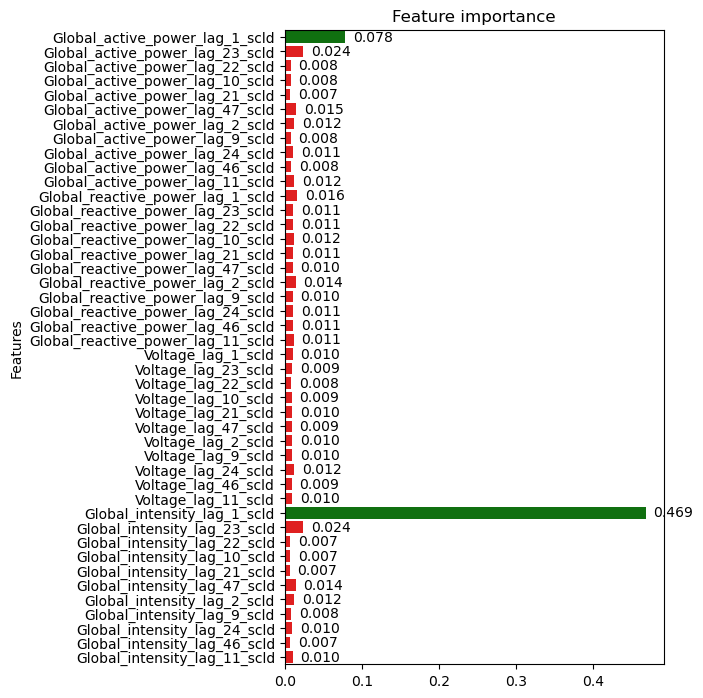

In [16]:
mod_rf, fit_rf, pred_rf = models.sklearn_random_forest(train, ytrain, test, ytest,\
                                                       n_est, r_st, path_figs, cm)

In [17]:
models.compute_evaluation_metrics(ytest, pred_rf, True)

MAE: 0.3813595805981591
MSE: 0.28916326522868685
MAPE: 0.5437477821165422
MSLE: 0.05679326864298127


(0.3813595805981591,
 0.28916326522868685,
 0.5437477821165422,
 0.05679326864298127)

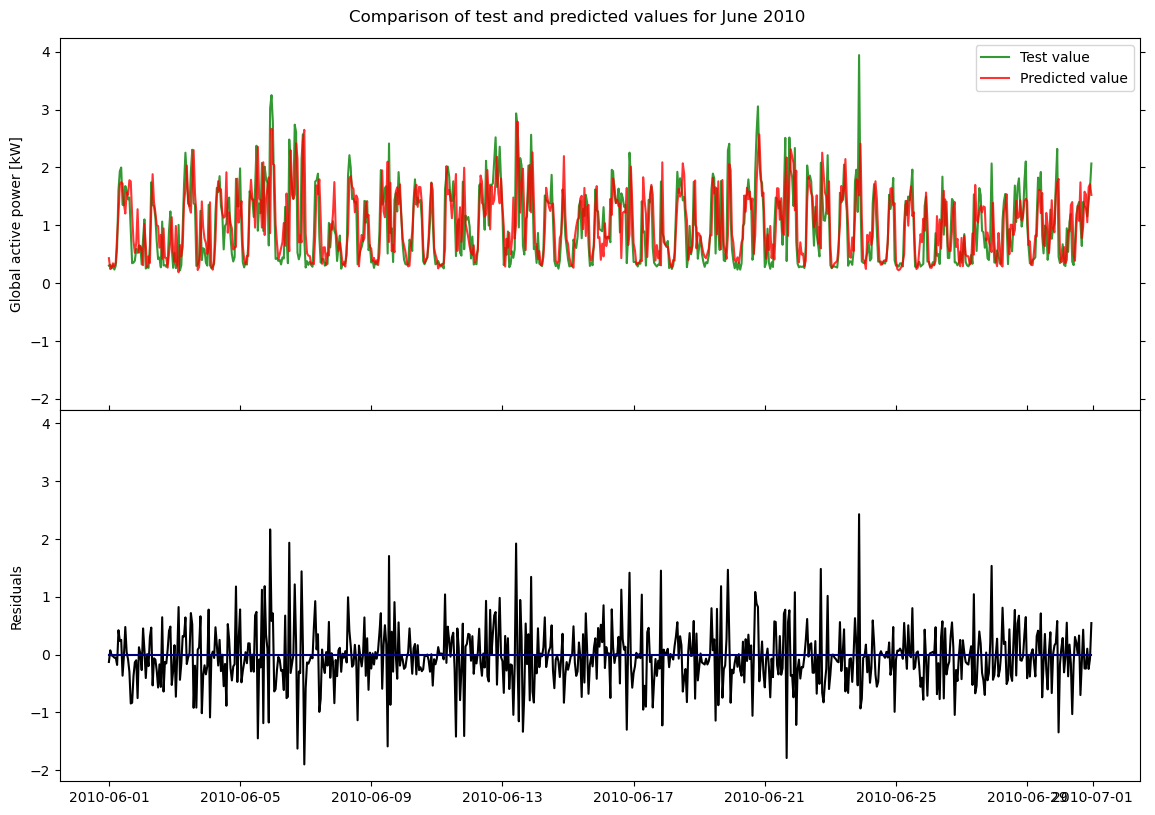

In [18]:
model_vis.plot_prediction_per_month(ytest, pred_rf, r'Global active power [kW]', 6, path_figs, \
                                    'Predictions_(random_forest)_global_active_power.pdf', cm)

# LightGBM MODEL

In [19]:
lgb_parameters = {
    "max_depth": [3,4,5,6],
    "num_leaves": [2,3,4,5,10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [10, 30, 50, 75, 100], #num_iterations
    "feature_fraction": [0.3, 0.5, 0.7],
    "min_data_in_bin": [1],
    "min_data_in_leaf": [1],
    "verbose": [-1],
}

In [20]:
pred_lgb = models.lgb_gridsearch(train, ytrain, test, ytest, lgb_parameters)

In [21]:
pred_lgb = data_prep.array_to_df(pred_lgb, test.index, ['pred']).squeeze()

In [28]:
models.compute_evaluation_metrics(ytest, pred_lgb, True)

MAE: 0.3526752425183959
MSE: 0.2668206450670941
MAPE: 0.4414887244187252
MSLE: 0.05025214907692256


(0.3526752425183959,
 0.2668206450670941,
 0.4414887244187252,
 0.05025214907692256)

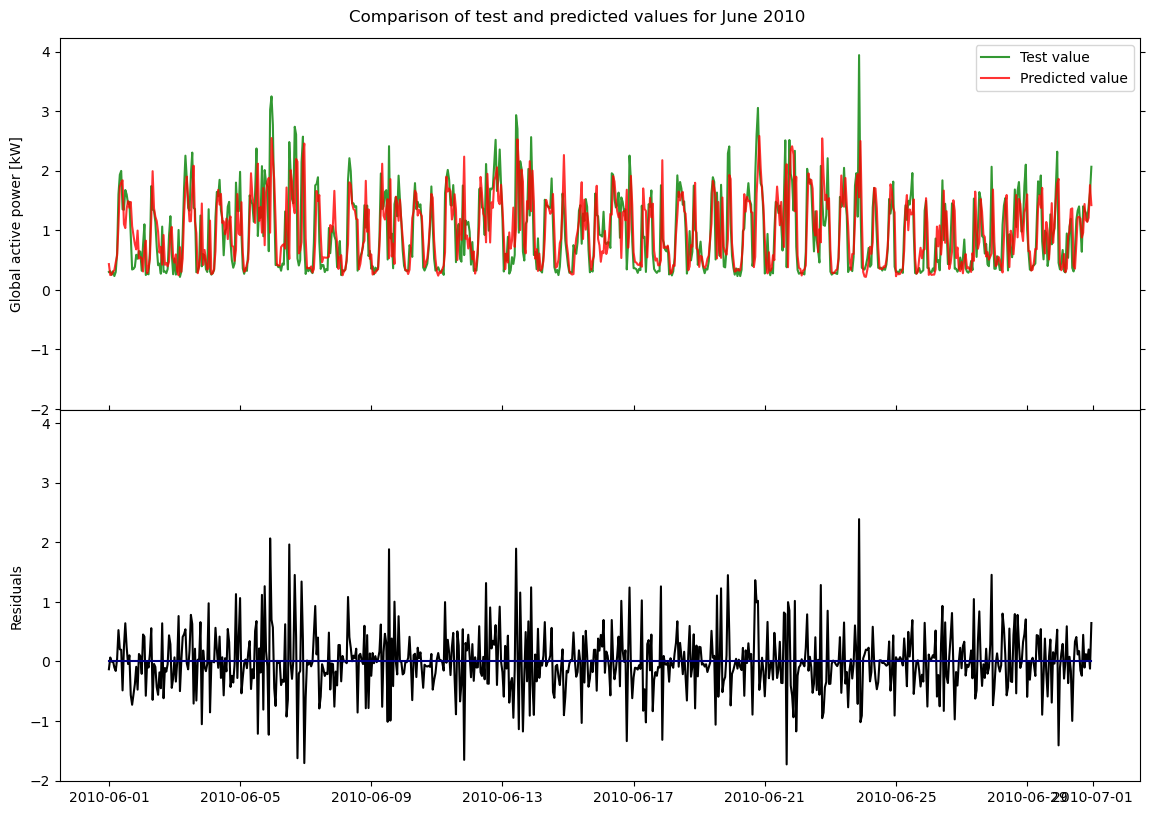

In [22]:
model_vis.plot_prediction_per_month(ytest, pred_lgb, r'Global active power [kW]', 6, path_figs, \
                                    'Predictions_(LGBoost)_global_active_power.pdf', cm)

# XGBOOST MODEL

In [23]:
xgb_parameters = {"max_depth": [3,4,5,6], \
                  "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3], \
                  "n_estimators": [10, 30, 50, 75, 100], \
                  "colsample_bytree": [0.3, 0.5, 0.7],
                  }

In [25]:
pred_xgb = models.xgb_gridsearch(train, ytrain, test, ytest, xgb_parameters)

In [26]:
pred_xgb = data_prep.array_to_df(pred_xgb, test.index, ['pred']).squeeze()

In [29]:
models.compute_evaluation_metrics(ytest, pred_xgb, True)

MAE: 0.3584825741051624
MSE: 0.2742260539324949
MAPE: 0.4701144327336181
MSLE: 0.05243915491350546


(0.3584825741051624,
 0.2742260539324949,
 0.4701144327336181,
 0.05243915491350546)

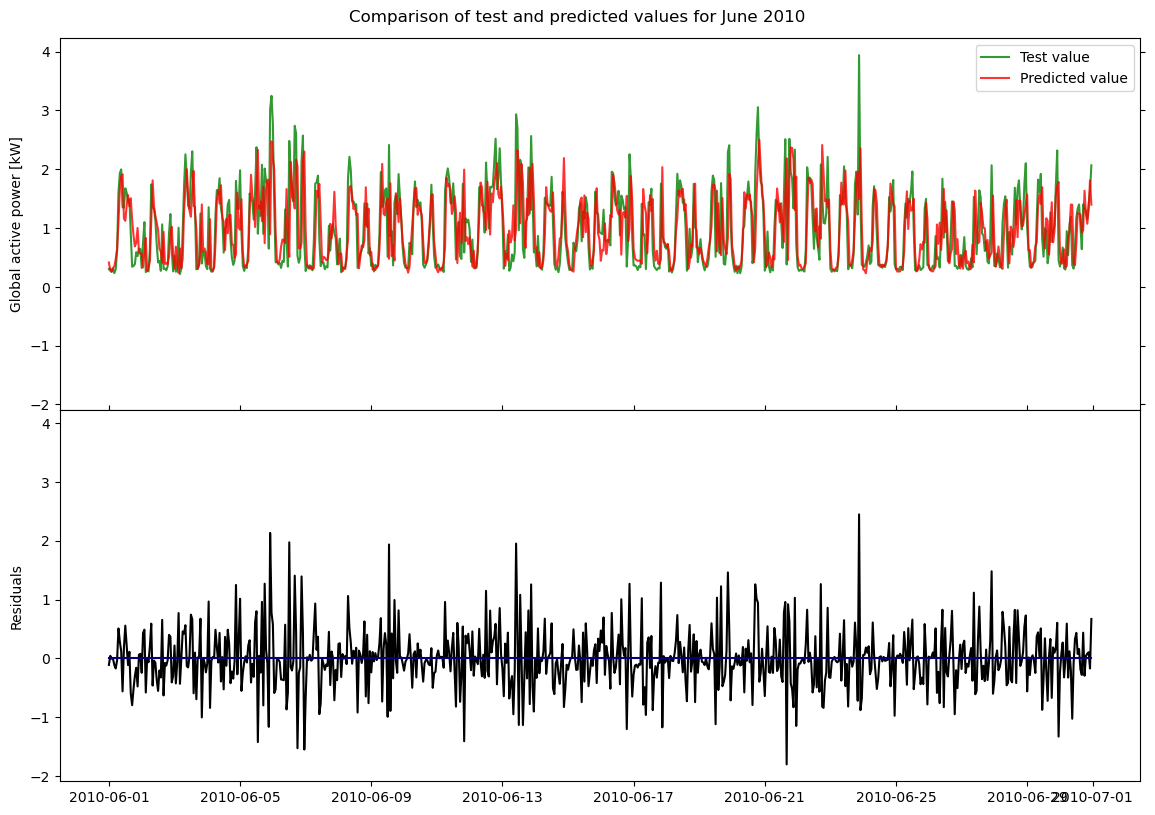

In [27]:
model_vis.plot_prediction_per_month(ytest, pred_xgb, r'Global active power [kW]', 6, path_figs, \
                                    'Predictions_(XGBoost)_global_active_power.pdf', cm)